In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import rotate
#for standardizing data matrix
from sklearn.preprocessing import scale
#for PCA
from sklearn.decomposition import PCA as sklearnPCA
#for randomly splitting data into training and test sets
from sklearn.model_selection import train_test_split
#linear regression package
from sklearn import linear_model 
#for hyperspectral decomposition
from sklearn.decomposition import FastICA, NMF
#for calculating p value
from scipy.stats import f
hyper_list=np.load('../MATDAT18_CorrelatedAFM/hyperspectral_2d.npy')
exp_wavenumber=np.load('../MATDAT18_CorrelatedAFM/wavenumber.npy')

First perform a 2 compnent NMF and look at the components. 

In [ ]:
NMF_model=NMF(n_components=2, init='random', random_state=0, max_iter=1000)
NMF_fit=NMF_model.fit_transform(hyper_list[:,1:])
NMF_comp=NMF_model.components_


In [ ]:
%matplotlib inline
for i in range(NMF_comp.shape[0]):
    plt.plot(exp_wavenumber[1:], NMF_comp[i,:], label = i) 
plt.legend()

#plt.plot(exp_wavenumber[1:], NMF_comp[0,:])
#plt.plot(exp_wavenumber[1:], NMF_comp[1,:])
plt.gca().invert_xaxis()
plt.title('Nonnegative Matrix Factorization Decomposition')
plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (a.u.)')

In [2]:
# Jessica's plotting function
def show(img, cmap = 'plasma', colorbar = True):
    """Displays image with colorbar."""
    fig = plt.imshow(img, cmap = cmap)
    imgstd = img.std()
    imgmean = img.mean()
    ll = imgmean - (2*imgstd)
    ul = imgmean + (2*imgstd)
    plt.clim(ll,ul)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if colorbar == True:
        plt.colorbar()
    return 

In [ ]:
to_plot=NMF_fit.reshape((231,247,2))

plt.figure(figsize=(10,5))
plt.subplot(121), show(to_plot[:,:,0]), plt.title('W0')
plt.subplot(122), show(to_plot[:,:,1]), plt.title('W1')
plt.show()


# Random Forest Regressor

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score, make_scorer
mse_scorer = make_scorer('mean_squared_error')
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


We want to predict the electrical current for a pixel using its spectra. The first step is to scale the electrical current, as it's on a pico (really really small) scale. So we use scikit's automatic function that standardizes by the standard deviation and centers on the mean. 

In [ ]:
#y=np.load("../MATDAT18_CorrelatedAFM/cAFM_registered.npy").reshape((57057))
#y=scale(y,axis=0)

Just kidding, that didn't work great in terms of unscaling. Instead, just multiply the response out of the pic scale by multiplying y*1e-12. 

In [4]:
y=np.load("../MATDAT18_CorrelatedAFM/cAFM_registered.npy").reshape((57057))
scaled_y = y*1e12

In [ ]:
# Use the NMF componenets as the covariates and current as the response
X = hyper_list[:,1:]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#kf.get_n_splits(X)

    
# build One model first
#X_train, X_test, y_train, y_test = train_test_split(X, scaled_y, test_size=0.2, random_state=0)
rf_regr = RandomForestRegressor(n_estimators=10)
#model = rf_regr.fit(X_train, y_train)

#make 5 folds
k_fold = KFold(n_splits=2, shuffle=True)

results = []
#feat_importance = []
for train, test in k_fold.split(X):
    model_fit = rf_regr.fit(X[train], scaled_y[train])
    pred = model_fit.predict(X[test])
    results.append(r2_score(scaled_y[test], pred))
    #feat_importance.append(model_fit.feature_importances_[0:50])
    
results    
#[rf_regr.fit(X[train], scaled_y[train]).score(X[test], scaled_y[test]) for train, test in k_fold.split(X)]


#regr_rf = RandomForestRegressor()
#regr_rf.fit(X_train, y_train)


#from sklearn import metrics
#cross_val_score(regr, X, y, cv=5, scoring=mse_scorer)

#for train_index, test_index in kf.split(X):
#    mod = regr.fit(X[, y)
#    print(mod.score())
#clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)


In [ ]:
important_features[0][0]

Great. So we have model scores, now we can perform a search for the best parameters using cross validation

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[10,50,100,500], 'max_features':(1,'auto')}
model = GridSearchCV(regr_rf, parameters, cv = 5,n_jobs = 4)
model.fit(X, scaled_y)

In [ ]:
y = np.load("../MATDAT18_CorrelatedAFM/cAFM_registered.npy").reshape((57057))
pred = model.best_estimator_.predict(X)
error = scaled_y - pred

In [ ]:

to_plot=pred.reshape((231,247))
plt.figure(figsize=(18,7))
plt.subplot(131), show(to_plot), plt.title('Predicted Scaled')
plt.subplot(132), show(scaled_y.reshape((231,247))), plt.title('Actual Scaled')
plt.subplot(133), show(error.reshape((231,247))), plt.title('Error')

plt.show()


We have an idea that the objects in this image should be trated differently. We'll use a quick edge detection algorithm to identify regions that need different models. If a pixel belongs to a region we'll use the regression model for that region type. Luckily this first image only has two regions :)

In [ ]:
import cv2
img = cv2.blur(NMF_fit.reshape((231,247,2))[:,:,1], (15,15))
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if(img[i,j] < 0.005):
            img[i,j] = 0
        else:
            img[i,j] = 255   
            

canny_edge = cv2.Canny(np.uint8(img),0,1)

# plt.subplot(121),plt.imshow(img,cmap = 'gray')
#plt.title('Original Image'), plt.xticks([]), plt.yticks([])
#plt.subplot(122),plt.imshow(edges,cmap = 'gray')
#plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
#plt.imshow('canny_edge', canny_edge)
#plt.imshow(img)
plt.imshow(canny_edge, cmap = 'gray')
plt.show()
plt.imshow(img, cmap = 'gray')
canny_edge


In [ ]:
type1 = NMF_fit.reshape((231,247,2))[np.where(img == 0)]
print(type1.shape)
type2 = NMF_fit.reshape((231,247,2))[np.where(img != 0)]
print(type2.shape)
#border_points = NMF_fit.reshape((231,247,2))[np.where(canny_edge == 1)]


In [5]:
#load the current and reshape to vector

#X = hyper_list[:,1:]
X = hyper_list[:,1:]
#y=np.load("../MATDAT18_CorrelatedAFM/cAFM_registered.npy").reshape((57057))
y=scaled_y#scale(y,axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#make 5 folds
#kf = KFold(n_splits=5)
#kf.get_n_splits(X)
# build One model first

regr_rf = RandomForestRegressor(n_estimators=15)
regr_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=15, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [6]:
pred =regr_rf.predict(X_test)
r2_score(y_test, pred)

0.9122261994694757

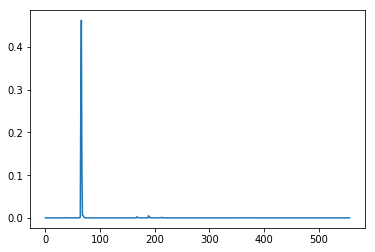

In [8]:
plt.plot(regr_rf.feature_importances_)

In [19]:
print(len(exp_wavenumber) - np.argsort(regr_rf.feature_importances_)[::-1][:5])
print(np.sort(regr_rf.feature_importances_)[::-1][:5])


[493 494 492 491 490]
[ 0.46255659  0.28902757  0.11738185  0.00620909  0.0053858 ]


# Comparing to Pure Spectra


In [ ]:
p3ht_ref=np.loadtxt('./data/p3ht_ref.txt', delimiter = '\t', skiprows=1)
pmma_ref=np.loadtxt('./data/pmma_ref.txt', delimiter = '\t', skiprows=1)
waves=np.loadtxt('./data/wavenumber_1129.txt', delimiter='\t', skiprows=1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
print(p3ht_ref.shape)
print(waves.shape)

#plt.plot(exp_wavenumber[1:], NMF_comp[0,:])
#plt.plot(exp_wavenumber[1:], NMF_comp[1,:])
p3ht_ref_scaled = (p3ht_ref - np.min(p3ht_ref))/(np.max(p3ht_ref)-np.min(p3ht_ref))
pmma_ref_scaled = (pmma_ref - np.min(pmma_ref))/(np.max(pmma_ref)-np.min(pmma_ref))
plt.plot(p3ht_ref_scaled[1:])
plt.plot(pmma_ref_scaled[1:])
#pmma_ref_scaled = scaler.fit(pmma_ref.reshape(1,-1))
#print(p3ht_ref_scaled.shape)

In [ ]:
comp0_scaled = (NMF_comp[0,:] - np.min(NMF_comp[0,:]))/(np.max(NMF_comp[0,:])-np.min(NMF_comp[0,:]))
comp1_scaled = (NMF_comp[1,:] - np.min(NMF_comp[1,:]))/(np.max(NMF_comp[1,:])-np.min(NMF_comp[1,:]))
plt.plot( comp0_scaled[::-1])
plt.plot( comp1_scaled[::-1])

In [ ]:
print(exp_wavenumber[558])
print(waves[0])

In [ ]:
from sklearn.metrics import mean_squared_error
exp_wavenumber.shape
i_comp0 = np.interp(waves,exp_wavenumber[1:], comp0_scaled[::-1])
print(mean_squared_error(p3ht_ref_scaled, i_comp0) + mean_squared_error(pmma_ref_scaled, i_comp1))

i_comp1 = np.interp(waves,exp_wavenumber[1:], comp1_scaled[::-1])
#print("PMMA and comp2 MSE:",mean_squared_error(pmma_ref_scaled, i_comp1))

print(mean_squared_error(pmma_ref_scaled, i_comp0) + mean_squared_error(p3ht_ref_scaled, i_comp1))
#print("P3ht and comp2 MSE:",mean_squared_error(p3ht_ref_scaled, i_comp1))